In [1]:
import torch
from PIL import Image
import requests
import numpy as np
from matplotlib import pyplot as plt
from detectron2.utils.visualizer import Visualizer

In [2]:
import os
import cv2

# Load Models

In [3]:
current_folder = globals()['_dh'][0]
print(current_folder)

/home/jacklishufan/uninext-segm/notebooks


In [4]:
os.chdir(os.path.join(current_folder, '..'))

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
from projects.HIPIE.demo_lib.part_segm_demo import PartSegmDemo
from detectron2.data.detection_utils import read_image,convert_PIL_to_numpy
from fairscale.nn.checkpoint import checkpoint_wrapper 

In [7]:
config_file = 'projects/HIPIE/configs/image_joint_r50_pan_maskdino_parts.yaml'
ckpt = 'weights/r50_parts.pth'
uninext_demo = PartSegmDemo(config_file=config_file,weight=ckpt,device='cpu')

Some weights of the model checkpoint at projects/HIPIE/bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


MASK_DINO has some weights not loaded, typically these are only predication and mask heads:_IncompatibleKeys(missing_keys=['pixel_decoder.mask_features.0.weight', 'pixel_decoder.mask_features.0.bias', 'pixel_decoder.mask_features.1.weight', 'pixel_decoder.mask_features.1.bias', 'pixel_decoder.mask_features.3.weight', 'pixel_decoder.mask_features.3.bias', 'pixel_decoder.adapter_1.weight', 'predictor.class_embed.weight', 'predictor.class_embed.bias', 'predictor.resizer.fc.weight', 'predictor.resizer.fc.bias', 'predictor.resizer.layer_norm.weight', 'predictor.resizer.layer_norm.bias', 'predictor._bbox_embed.layers.0.weight', 'predictor._bbox_embed.layers.0.bias', 'predictor._bbox_embed.layers.1.weight', 'predictor._bbox_embed.layers.1.bias', 'predictor._bbox_embed.layers.2.weight', 'predictor._bbox_embed.layers.2.bias', 'predictor.bbox_embed.0.layers.0.weight', 'predictor.bbox_embed.0.layers.0.bias', 'predictor.bbox_embed.0.layers.1.weight', 'predictor.bbox_embed.0.layers.1.bias', 'predic

Some model parameters or buffers are not found in the checkpoint:
detr.mask_dino.predictor.resizer.fc.{bias, weight}
detr.mask_dino.predictor.resizer.layer_norm.{bias, weight}
The checkpoint state_dict contains keys that are not used by the model:
  detr.mask_dino.predictor.label_enc.weight


Length of coco_panoptic Categories : 133
Length of pascal_parts_val Categories : 200
Length of coco_2017_train_panoptic_with_sem_seg Categories : 133


In [8]:
uninext_demo.demo.predictor.model.device = 'cpu'

# Set up an image

In [78]:
# url = 'https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo.png'
# url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/e/ec/Mona_Lisa%2C_by_Leonardo_da_Vinci%2C_from_C2RMF_retouched.jpg/405px-Mona_Lisa%2C_by_Leonardo_da_Vinci%2C_from_C2RMF_retouched.jpg'
# url = 'https://encrypted-tbn0.gstatic.com/licensed-image?q=tbn:ANd9GcSh82Dm7OEK7SU7Rnv3Fa-9bi6BZrMM0NJvtm94eGajmxl7mObM7Jp9h3z5UfxaY5IsXGBoB9IX1QMVMlE'
#url = 'https://hips.hearstapps.com/hmg-prod/images/dog-puppy-on-garden-royalty-free-image-1586966191.jpg?crop=0.752xw:1.00xh;0.175xw,0&resize=1200:*'
#image = Image.open(requests.get(url,stream=True).raw)
image = Image.open('assets/demo_hipie.jpg')
image_np_d2 = convert_PIL_to_numpy(image, format="BGR")

In [79]:
from detectron2.projects.hipie.data.coco_dataset_mapper_uni import get_openseg_labels
COCO_OPENSEG_LABELS = get_openseg_labels('coco_panoptic')
coco_labels = dict(
    things_labels=[x['name'] for x in get_openseg_labels('coco_panoptic')[:80]],
    stuff_labels=[x['name'] for x in get_openseg_labels('coco_panoptic')[80:]]
)
custom_labels = dict(
    things_labels=['cats','books','mouse','bottle','clock','cellphone'],
    stuff_labels=['sky','shelf','table']
)

In [80]:
selected_labels = coco_labels

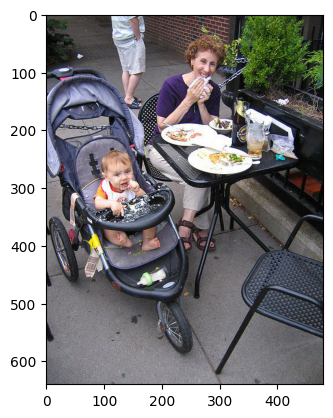

In [81]:
plt.imshow(image)

In [97]:
mask = uninext_demo.foward_panoptic(image_np_d2,do_part=True,instance_thres=0.49,**selected_labels)

# Panoptic Seg

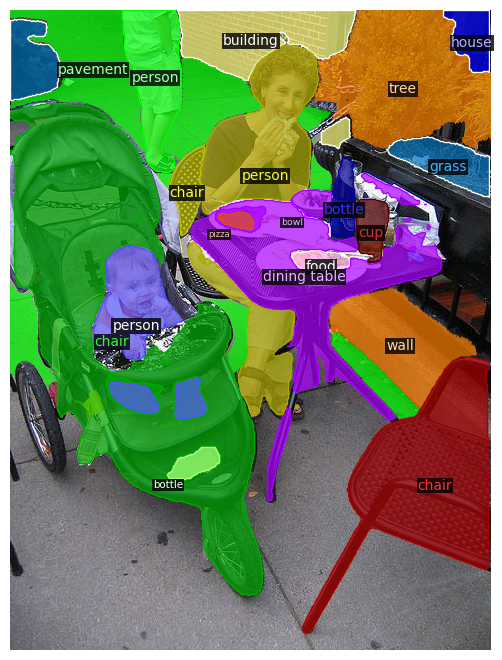

In [98]:
visualizer = Visualizer(image,metadata=mask['meta_data'])
visualizer.draw_panoptic_seg(mask['panoptic_seg'][0].cpu(),mask['panoptic_seg'][1])
visualizer.get_output().fig

#  Part Seg

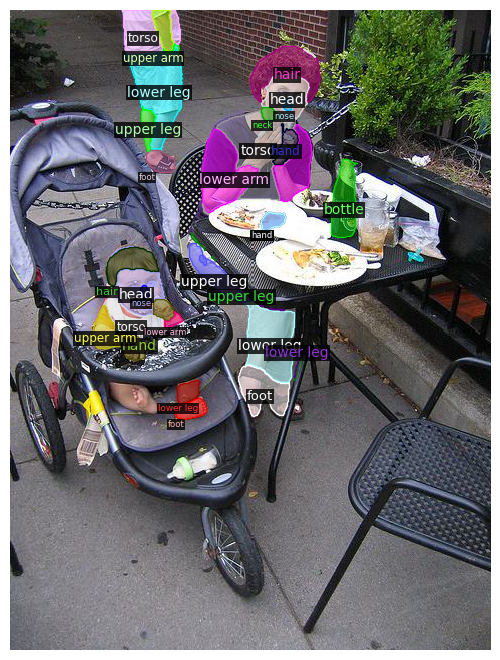

In [99]:
visualizer = Visualizer(image)
visualizer.overlay_instances(masks=torch.stack(mask['output_refined'][0]),labels=mask['output_refined'][1])
visualizer.get_output().fig

# Instance Seg

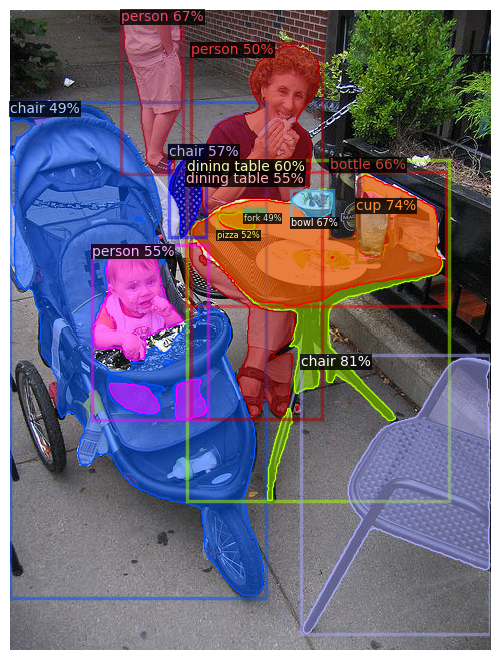

In [100]:
visualizer = Visualizer(image,metadata=mask['meta_data'])
visualizer.draw_instance_predictions(mask['instances'].to('cpu'))
visualizer.get_output().fig

In [ ]:
ref_str = "the mother behind table"
mask = uninext_demo.foward_reference(image_np_d2,ref_str,'')

In [ ]:
vis= Visualizer(image)
#vis.overlay_instances(masks=mask['instance_mask'])
#vis.overlay_instances(masks=part_mask)
vis.overlay_instances(masks=[mask['final_mask'][0].numpy()],labels=[ref_str])
vis.get_output().fig